In [9]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM, 
                        AutoTokenizer, 
                        BitsAndBytesConfig, 
                        TrainingArguments, 
                        pipeline, 
                        logging)
import warnings
warnings.filterwarnings("ignore")

from peft import LoraConfig, PeftConfig
from trl import SFTTrainer

from sklearn.metrics import (accuracy_score, 
                            classification_report, 
                            confusion_matrix)
from sklearn.model_selection import train_test_split

peft, trl, bitsandbytes

In [14]:
df = pd.read_csv('../datasets/sentiment_dataset.csv',
                names=['sentiment', 'text'],
                encoding='utf-8', encoding_errors='replace')

In [58]:
df.head(2)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...


<Axes: xlabel='Sentiment', ylabel='Count'>

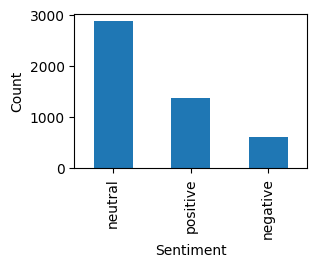

In [25]:
df.value_counts('sentiment').plot(kind='bar', 
                figsize=(3, 2), xlabel='Sentiment', ylabel='Count')

In [100]:
data_df = df.copy(deep=True)

In [107]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from makeDataset import *


# Preprocess your data
le = LabelEncoder()
data_df['sentiment_encoded'] = le.fit_transform(data_df['sentiment'])
device = torch.device('cuda')

# Split the data into train and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
model = model.to(device)

# Define training parameters
batch_size = 16
epochs = 5
lr = 2e-5

# Create dataloaders
train_dataset = CustomDataset(train_df['text'], train_df['sentiment_encoded'], tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_df['text'], val_df['sentiment_encoded'], tokenizer, max_len=128)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=lr)
loss_fn = CrossEntropyLoss()

### Training the finbert model 

In [108]:
max_val_accuracy = -1
# Training loop
train_accuracy_list = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    correct_preds = 0
    total_preds = 0
    
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        
        loss.backward()        
        optimizer.step()
        
        _, predicted = torch.max(outputs.logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    train_accuracy = correct_preds / total_preds
    train_accuracy_list.append(train_accuracy)
    avg_train_loss = train_loss / len(train_loader)
    print(f'Training Loss: {avg_train_loss:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_preds / total_preds
    
    if max_val_accuracy < val_accuracy:
        max_val_accuracy = val_accuracy
        model.save_pretrained("../finbert_finetuned")
    
    print(f'Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')

# Save the fine-tuned model
# load the saved model
# model = BertForSequenceClassification.from_pretrained("../finbert_finetuned")

Training Loss: 0.9226
Validation Loss: 0.4273 | Validation Accuracy: 0.8258


Training Loss: 0.3431
Validation Loss: 0.5125 | Validation Accuracy: 0.8299


Training Loss: 0.1648
Validation Loss: 0.5246 | Validation Accuracy: 0.8464
